In [1]:
from glob import glob
import os
import pickle
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [6]:
directory_path = "../../data/preprocessed"
output_dir = "../../data/preprocessed"
def iterate_files(action, n=1):
    files = sorted(glob(os.path.join(directory_path, "events-*.pkl")))
    files = files[:n]
    
    for filename in tqdm(files, ncols=100, desc="Processing"):
        file_path = os.path.join(directory_path, filename)
        file_name = os.path.splitext(filename)[0]
    
        df = pd.read_pickle(file_path)
        action(file_name, df)

In [28]:
event_dates = []
def get_event_date(file_name, df):
    # add tuples of (id, date) to event_dates
    event_dates.extend([(i, row['info']['eventDate']) for i, row in df.iterrows()])

In [41]:
iterate_files(get_event_date, 3000)

Processing: 100%|███████████████████████████████████████████████| 2944/2944 [01:50<00:00, 26.58it/s]


In [55]:
event_df = pd.DataFrame(event_dates, columns=['id', 'event_date'])
event_df.set_index('id', inplace=True)
# sort df by event_date (desc)
event_df['event_date'] = event_df['event_date'].astype(int)
event_df.sort_values(by='event_date', inplace=True, ascending=False)

In [57]:
def days_timestamp_to_date(days):
    # confirmed to be correct
    return pd.to_datetime(days, unit='D', origin=pd.Timestamp('1970-01-01')) 
# create a new column by applying days_timestamp_to_date to event_date
event_df['date'] = days_timestamp_to_date(event_df['event_date'])

In [60]:
event_df[event_df['event_date'] != 0].iloc[-100:]

,event_date,date
id,,
e_659738,2274,1976-03-24
e_382106,2224,1976-02-03
e_836438,2151,1975-11-22
e_421104,2149,1975-11-20
e_911428,1910,1975-03-26
...,...,...
e_1973176,-3321,1960-11-28
e_1398704,-3384,1960-09-26
e_1092281,-3547,1960-04-16


In [62]:
with open('../../data/preprocessed/event_index.pkl', 'rb') as f:
    event_index = pickle.load(f)

In [68]:
# find e_2058117 in event_index
for file_name, event_ids in event_index.items():
    if 'e_659738' in event_ids :
        print(file_name)

../../data/preprocessed/events-00660


<Axes: ylabel='Frequency'>

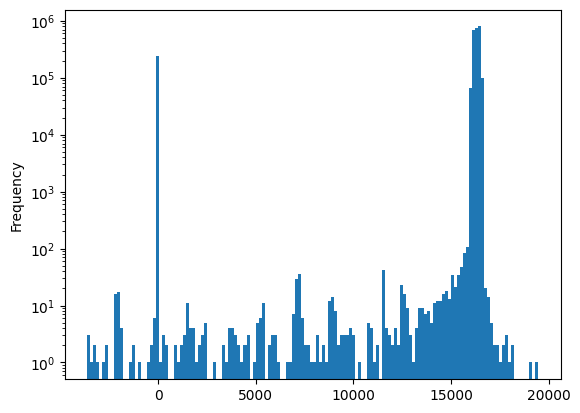

In [73]:
# plot the distribution of event_date on a log scale
event_df['event_date'].plot.hist(bins=150, log=True)

In [131]:
# 1.6.2014 in days
start = 16000
# 1.1.2016 in days
end = 16650
days_timestamp_to_date(start), days_timestamp_to_date(end)

(Timestamp('2013-10-22 00:00:00'), Timestamp('2015-08-03 00:00:00'))

In [132]:
events = event_df[(event_df['event_date'] >= start) & (event_df['event_date'] <= end)]
top_10 = events['event_date'].quantile(0.9)
recent_10 = events[events['event_date'] > top_10]
random_10 = events.sample(frac=0.1)

<Axes: ylabel='Frequency'>

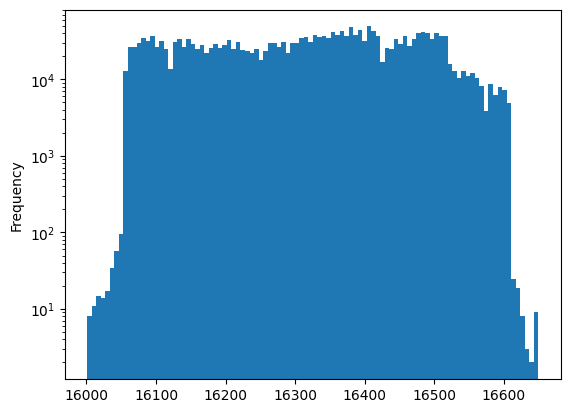

In [135]:
events['event_date'].plot.hist(bins=100, log=True)

<Axes: ylabel='Frequency'>

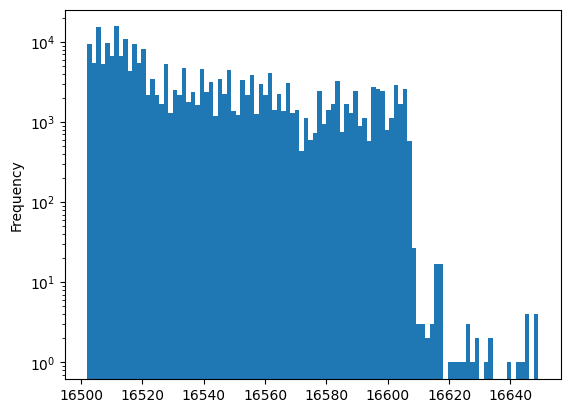

In [136]:
recent_10['event_date'].plot.hist(bins=100, log=True)

<Axes: ylabel='Frequency'>

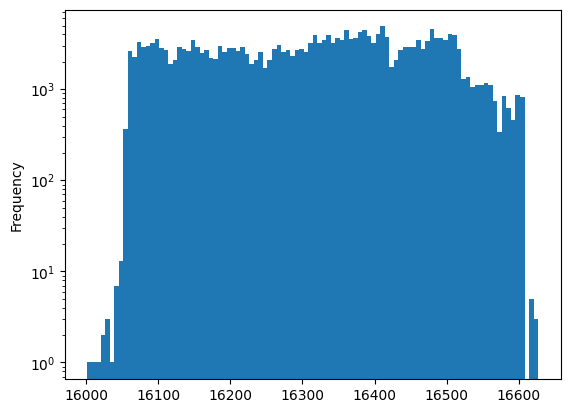

In [137]:
random_10['event_date'].plot.hist(bins=100, log=True)